In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we will build a **CNN** for images from CIFAR10 dataset.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<br/>
    <img src='../images/cifar_data.png' width=50% height=50% />
<br/>

### Loading CIFAR10 dataset into train-val-test set

In [1]:
import torchvision.transforms as transforms 
import torchvision.datasets as datasets

**train-test-transform**

In [2]:
# Define a transform to normalize the data
train_transform = transforms.Compose([transforms.RandomResizedCrop((32, 32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)

# val-dataset refers to the same dataset as train-dataset, however, while validating the model's performance
# we do not use any random-transformation
val_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=test_transform)

test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


**Separating train-set into train & validation set**
- Let's set validation set size as 20%, therefore, we will be using 80% of training set for training 
    the neural network
- Validating a model while training w.r.t a validation-set can help us from overfitting
- Validation-set works as an alternative to the actual test-set, as it is assumed that while training 
    we do not have any access to the test-set 

In [4]:
train_set_size = len(train_dataset)
print('train-set-size: {}'.format(train_set_size))

train-set-size: 50000


In [6]:
import numpy as np

all_indices = list(range(train_set_size))
print('len(all_indices): '.format(len(all_indices)))

np.random.shuffle(all_indices)

val_size = int(0.2 * len(all_indices))
train_size = len(all_indices) - val_size
print('val-size: {} train-size: {}'.format(val_size, train_size))

val_indices = all_indices[:val_size]
train_indices = all_indices[val_size:]

print('len(train_indices): {} len(val_indices): {}'.format(len(train_indices), len(val_indices)))

len(all_indices): 
val-size: 10000 train-size: 40000
len(train_indices): 40000 len(val_indices): 10000


In [9]:
from torch.utils.data import SubsetRandomSampler
import torch

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           sampler=SubsetRandomSampler(train_indices), num_workers=4, 
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                        sampler=SubsetRandomSampler(val_indices), num_workers=4,
                                        pin_memory=True)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,
                                          num_workers=4, pin_memory=True)

In [18]:
train_data, train_targets = next(iter(train_loader))
val_data, val_targets = next(iter(val_loader))
test_data, test_targets = next(iter(test_loader))

In [12]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [15]:
import matplotlib.pyplot as plt

### Visualize a Batch of Training Data

In [16]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

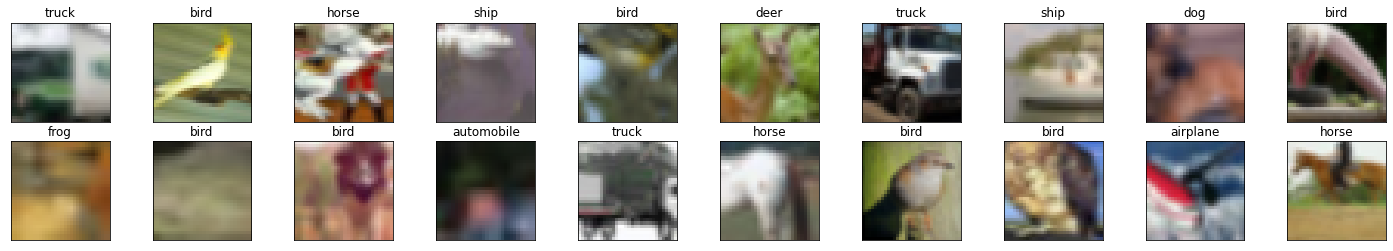

In [19]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(train_data[idx])
    ax.set_title(classes[train_targets[idx]])

### Visualize a Batch of Validation Data

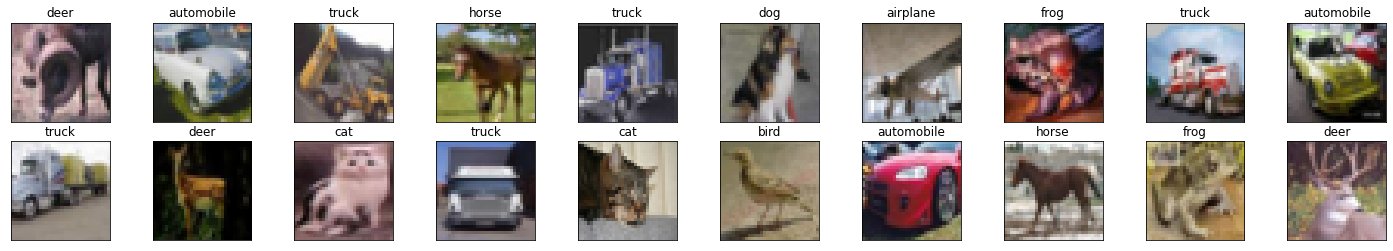

In [20]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(val_data[idx])
    ax.set_title(classes[val_targets[idx]])

### Visualize a Batch of Test Data

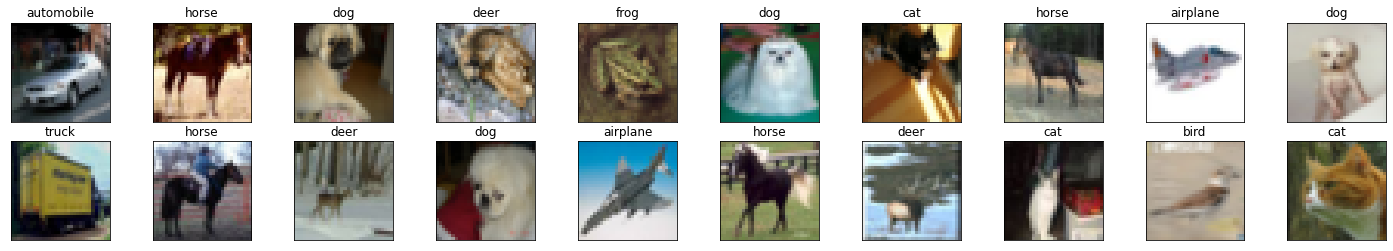

In [21]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(test_data[idx])
    ax.set_title(classes[test_targets[idx]])

In [22]:
!python --version

Python 3.7.7


## Define CNN Architecture

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels: int=3, num_classes: int=10) -> None:
        super(CNN, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes

        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # add sequence of convolutional and max pooling layers
        out = self.pool(F.relu(self.conv1(x)))
        out = self.pool(F.relu(self.conv2(out)))
        out = self.pool(F.relu(self.conv3(out)))
        # flatten image input
        out = out.view(-1, 64 * 4 * 4)
        # add dropout layer
        out = self.dropout(out)
        # add 1st hidden layer, with relu activation function
        out = F.relu(self.fc1(out))
        # add dropout layer
        out = self.dropout(out)
        # add 2nd hidden layer, with relu activation function
        out = self.fc2(out)
        return out

In [24]:
model = CNN()
print(model)

data = torch.randn(10, 3, 32, 32)
with torch.no_grad():
    output = model(data)

print('data.shape: {} output.shape: {}'.format(data.size(), output.size()))

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
data.shape: torch.Size([10, 3, 32, 32]) output.shape: torch.Size([10, 10])


## CNN training

In [25]:
import torch
import torch.nn as nn
from torch.nn import DataParallel
import time
import torch.optim as optim

from typing import Tuple, Any, List

def trainCls(model: nn.Module, train_loader: torch.utils.data.DataLoader, 
             val_loader: torch.utils.data.DataLoader, lr: float=0.1, epochs: int=100, 
             momentum: float=0.9, weight_decay: float=5e-4, 
             checkpoint: str='./checkpoint') -> Tuple[nn.Module, List, List, List, List]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # optimizer is used to optime the model parameters while doing back-propagation
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    best_acc = 0.0
    
    trainLoss_, valLoss_ = list(), list()
    trainAcc_, valAcc_ = list(), list()
    
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            model.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            train_acc += predicted.eq(target).sum().item()
        
        train_loss, train_acc = train_loss/len(train_loader.sampler), train_acc/len(train_loader.sampler)
        trainLoss_.append(train_loss)
        trainAcc_.append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        for _, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            val_acc += predicted.eq(target).sum().item()
        
        val_loss, val_acc = val_loss/len(val_loader.sampler), val_acc/len(val_loader.sampler)
        valLoss_.append(val_loss)
        valAcc_.append(val_acc)

        if val_acc > best_acc:
            print('Epoch: {} val accuracy improved: {:0.4f} ==> {:0.4f}'.format(epoch+1, best_acc, val_acc))
            best_acc = val_acc

            try:
                state_dict = model.state_dict()
            except:
                state_dict = model.module.state_dict()

            torch.save(state_dict, checkpoint)

        print('Epoch: [{}/{}] train_acc: {:0.4f} val_acc: {:0.4f} train_loss: {:0.4f} val_loss: {:0.4f}'.format(epoch+1, epochs, train_acc, val_acc, train_loss, val_loss))

    total_time = time.time() - start
    print('time: {:0.0f}m {:0.0f}s'.format((total_time//60), (total_time%60)))
    
    # loading model's best saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    return model, trainLoss_, valLoss_, trainAcc_, valAcc_

In [26]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='cnn_cifar10_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.2452
Epoch: [1/100] train_acc: 0.1447 val_acc: 0.2452 train_loss: 2.2731 val_loss: 2.1217
Epoch: 2 val accuracy improved: 0.2452 ==> 0.3206
Epoch: [2/100] train_acc: 0.2354 val_acc: 0.3206 train_loss: 2.0655 val_loss: 1.8958
Epoch: 3 val accuracy improved: 0.3206 ==> 0.3652
Epoch: [3/100] train_acc: 0.2840 val_acc: 0.3652 train_loss: 1.9400 val_loss: 1.7483
Epoch: 4 val accuracy improved: 0.3652 ==> 0.3957
Epoch: [4/100] train_acc: 0.3075 val_acc: 0.3957 train_loss: 1.8637 val_loss: 1.6686
Epoch: 5 val accuracy improved: 0.3957 ==> 0.4114
Epoch: [5/100] train_acc: 0.3304 val_acc: 0.4114 train_loss: 1.8111 val_loss: 1.6216
Epoch: 6 val accuracy improved: 0.4114 ==> 0.4334
Epoch: [6/100] train_acc: 0.3474 val_acc: 0.4334 train_loss: 1.7705 val_loss: 1.5400
Epoch: 7 val accuracy improved: 0.4334 ==> 0.4500
Epoch: [7/100] train_acc: 0.3588 val_acc: 0.4500 train_loss: 1.7411 val_loss: 1.5108
Epoch: 8 val accuracy improved: 0.4500 =

Epoch: [71/100] train_acc: 0.5985 val_acc: 0.7187 train_loss: 1.1327 val_loss: 0.7985
Epoch: [72/100] train_acc: 0.6011 val_acc: 0.7205 train_loss: 1.1244 val_loss: 0.7937
Epoch: [73/100] train_acc: 0.6033 val_acc: 0.7215 train_loss: 1.1267 val_loss: 0.7979
Epoch: 74 val accuracy improved: 0.7295 ==> 0.7343
Epoch: [74/100] train_acc: 0.6038 val_acc: 0.7343 train_loss: 1.1197 val_loss: 0.7656
Epoch: [75/100] train_acc: 0.6051 val_acc: 0.7260 train_loss: 1.1189 val_loss: 0.7853
Epoch: [76/100] train_acc: 0.5997 val_acc: 0.7170 train_loss: 1.1309 val_loss: 0.8034
Epoch: [77/100] train_acc: 0.6066 val_acc: 0.7230 train_loss: 1.1167 val_loss: 0.7861
Epoch: [78/100] train_acc: 0.6065 val_acc: 0.7331 train_loss: 1.1168 val_loss: 0.7650
Epoch: 79 val accuracy improved: 0.7343 ==> 0.7366
Epoch: [79/100] train_acc: 0.6072 val_acc: 0.7366 train_loss: 1.1129 val_loss: 0.7520
Epoch: [80/100] train_acc: 0.6099 val_acc: 0.7275 train_loss: 1.1092 val_loss: 0.7804
Epoch: [81/100] train_acc: 0.6109 val_

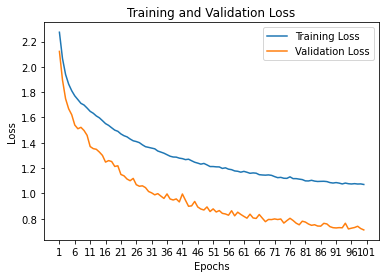

In [27]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

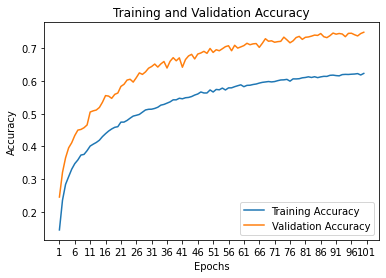

In [28]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

---
## Test the Trained Network


In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

model.to(device) # loading model to device

if torch.cuda.device_count() > 1:
    if not isinstance(model, DataParallel):
        model = DataParallel(model) # if more that one gpu is available,
                                    # then wrap model with DataParallel,
                                    # so that it can be trained on multiple gpus

model.to(device) # load model to device

device: cuda:0


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [30]:
# loading model's best saved weight
checkpoint = 'cnn_cifar10_best_model.pth'

try:
    model.load_state_dict(torch.load(checkpoint, map_location=device))
except:
    model.module.load_state_dict(torch.load(checkpoint, map_location=device))

In [35]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

criterion = nn.CrossEntropyLoss()

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    batch_size = min(64, data.size(0))
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:0.4f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.7340

Test Accuracy of airplane: 83% (832/1000)
Test Accuracy of automobile: 87% (872/1000)
Test Accuracy of  bird: 52% (521/1000)
Test Accuracy of   cat: 48% (483/1000)
Test Accuracy of  deer: 72% (725/1000)
Test Accuracy of   dog: 71% (716/1000)
Test Accuracy of  frog: 88% (887/1000)
Test Accuracy of horse: 81% (812/1000)
Test Accuracy of  ship: 82% (821/1000)
Test Accuracy of truck: 84% (849/1000)

Test Accuracy (Overall): 75% (7518/10000)


### Visualize Sample Test Results

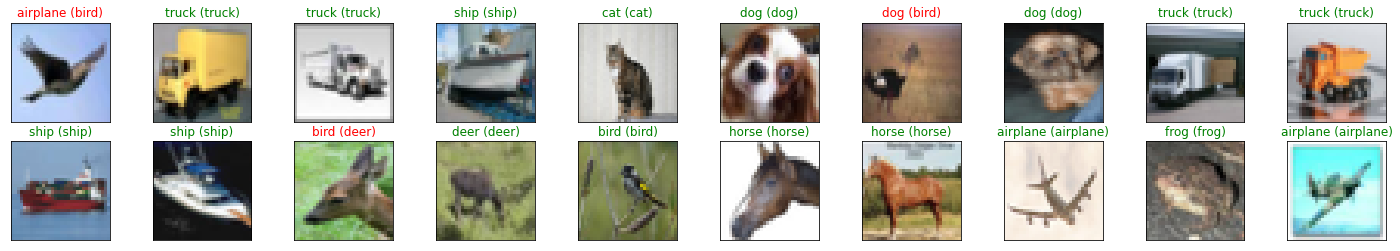

In [38]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not torch.cuda.is_available() else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))